In [1]:
#Use the HGP-SL model on the hERG training set

In [1]:
import os
import sys
import shutil

import numpy as np
import pandas as pd

import enlighten

from IPython.core.display import HTML


import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv

from layers import GCN, HGPSLPool

from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU
import torch_geometric.transforms as T
from torch_sparse import coalesce
from torch_geometric.data import (InMemoryDataset, Data, download_url)
from torch_scatter import scatter
from torch_geometric.utils import remove_self_loops

#RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import PandasTools
from rdkit import RDLogger

RDLogger.logger().setLevel(RDLogger.CRITICAL)

import time
import glob


In [2]:
#fcts
def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))


In [3]:
assay = 1511
global dataset
# filename = f'{assay}_dataset.pt'
dataset = f'{assay}_dataset.pt'
global input_sdf
input_sdf = f'{assay}_compounds.sdf'
global directory
directory = f'{assay}_data'

In [4]:
#setup dataset
sdfpath = os.path.join(os.getcwd(), f'{assay}_compounds.sdf')
backup_df = PandasTools.LoadSDF(sdfpath)
dataframe = backup_df.copy()

,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,ID,ROMol
0,1511,56314828,1988,Inactive,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,
1,1511,56321651,425322,Inactive,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,
2,1511,56322145,24981957,Inactive,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,
3,1511,51090143,7384392,Inactive,CCS(=O)(=O)N1CCC2(CC1)N(CCO2)S(=O)(=O)C3=CC=C(...,,
4,1511,51090795,7423030,Inactive,CC1=NC(=NC=C1)NC(=O)CCN2C(=O)C3=CC=CC=C3S2(=O)=O,,

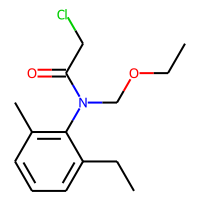
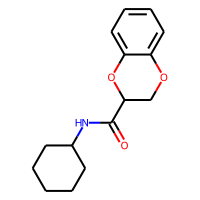
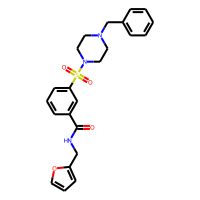
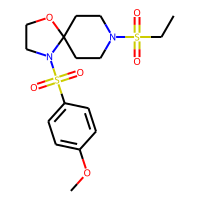
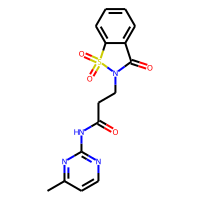

In [5]:
show(dataframe.head(5))

In [6]:
import csv

global element_dict
elements = []

if os.path.exists('element_list.json'):
    pass
else:
    with open('periodictable.csv', 'r') as ifile:
        reader = csv.reader(ifile)
        for i in reader:
            element = i[1]
            elements.append(element)

    indexes = [i for i in range(len(elements))]


    element_dict = dict(zip(elements, indexes))

In [7]:
#save to file for future use
import json

if os.path.exists('element_list.json'):
    with open('element_list.json', 'r') as listfile:
        element_dict = json.load(listfile)
else:
    with open('element_list.json', 'w') as listfile:
        json.dump(element_dict, listfile)

In [8]:
#setup filesystem
import shutil

rawdir = os.path.join(directory, 'raw')
processdir = os.path.join(directory, 'processed')

try:
    os.mkdir(directory)
    # rawdir = os.path.join(directory, 'raw')
    # processdir = os.path.join(directory, 'processed')
    os.mkdir(rawdir)
    os.mkdir(processdir)
except FileExistsError:
    print("Directory already exists")
    pass
finally:
    shutil.copyfile(os.path.abspath(input_sdf), os.path.join(rawdir, input_sdf))
    
    
    


Directory already exists


In [9]:
dataframe["PUBCHEM_ACTIVITY_OUTCOME"].replace("Inactive", 0, inplace=True)
dataframe["PUBCHEM_ACTIVITY_OUTCOME"].replace("Active", 1, inplace=True)

In [10]:
dataframe.PUBCHEM_ACTIVITY_OUTCOME.value_counts()

0    304127
1      1552
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

In [11]:
global targets
targets = dataframe.PUBCHEM_ACTIVITY_OUTCOME.to_list()

In [12]:
class BioAssayDataset(InMemoryDataset):
    def __init__(self, root=None, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [input_sdf]
    
    @property
    def processed_file_names(self):
        return [dataset]
    
    def download(self):
        pass

    def process(self):
        data_list = []

        bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}
        types = element_dict


        # mol_list = Chem.SDMolSupplier(self.raw_paths[0], removeHs=False, sanitize=False)
        mol_list = Chem.SDMolSupplier(self.raw_paths[0], removeHs=False)
        pbar = enlighten.Counter(total=len(mol_list), desc='Encoding molecules...', unit='ticks')
        for ID, mol in enumerate(mol_list):
            #number of atoms
            n_a = mol.GetNumAtoms()


            conf = mol.GetConformer()
            pos = conf.GetPositions()
            pos = torch.tensor(pos, dtype=torch.float)

            #atom features
            type_idx = []
            atomic_number = []
            aromatic = []
            sp = []
            sp2 = []
            sp3 = []
            num_hs = []
        
            for atom in mol.GetAtoms():
                #need to implement this
                type_idx.append(types[atom.GetSymbol()])

                atomic_number.append(atom.GetAtomicNum())
                aromatic.append(1 if atom.GetIsAromatic() else 0)
                hybridisation = atom.GetHybridization()
                sp.append(1 if hybridisation == HybridizationType.SP else 0)
                sp2.append(1 if hybridisation == HybridizationType.SP2 else 0)
                sp3.append(1 if hybridisation == HybridizationType.SP3 else 0)
                num_hs.append(atom.GetTotalNumHs(includeNeighbors=True))

            z = torch.tensor(atomic_number, dtype=torch.long)            

            #bonds
            row, col, edge_type = [], [], []
            for bond in mol.GetBonds():
                start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                row += [start, end]
                col += [end, start]
                edge_type += 2 * [bonds[bond.GetBondType()]]

            edge_index = torch.tensor([row, col], dtype=torch.long)
            edge_type = torch.tensor(edge_type, dtype=torch.long)
            edge_attr = F.one_hot(edge_type,num_classes=len(bonds)).to(torch.float)

            # perm = (edge_index[0] * n_a + edge_index[1]).argsort()

            # # print(edge_index[0])
            # # print(edge_index[0])
            # # print(n_a)
            # edge_index = edge_index[:, perm]
            # edge_type = edge_type[perm]
            # edge_attr = edge_attr[perm]

            # row, col = edge_index
            # hs = (z==1).to(torch.float)
            # num_hs = scatter(hs[row], col, dim_size=n_a).tolist()

            x1 = F.one_hot(torch.tensor(type_idx), num_classes=len(types))
            x2 = torch.tensor([atomic_number, aromatic, sp, sp2, sp3, num_hs], dtype=torch.float).t().contiguous()
            x = torch.cat([x1.to(torch.float), x2], dim=-1)

            #target is the binarised activities
            y = targets[ID]

            name = mol.GetProp('_Name')

            data = Data(x=x, z=z, pos=pos, edge_index=edge_index, edge_attr=edge_attr, y=y, name=name, idx=ID)
            data_list.append(data)
            pbar.update()
        torch.save(self.collate(data_list), self.processed_paths[0])

    #need to add process functions for the molecules

# class MyTransfrom(object):
#     def __call__(self, data):
#         print(data)
#         data.y = data.y[:, targets]
#         print(data.y)
#         return data
        
class Complete(object):
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data


In [13]:
# print(directory)
# transform = T.Compose([MyTransfrom(), Complete(), T.Distance(norm=False)])
transform = T.Compose([Complete(), T.Distance(norm=False)])

dataset = BioAssayDataset(directory, transform=transform).shuffle()

In [14]:
dataset.data.y.view(1,-1).shape

torch.Size([1, 305679])

In [17]:
for x in dataset:
    print(x)
    break

Data(x=[29, 124], edge_index=[2, 812], edge_attr=[812, 5], y=[1], pos=[29, 3], z=[29], name='', idx=[1])


In [18]:
#split datasets into train/test

td_len = len(dataset)
tr_part = round(td_len*0.8)
val_part = round(td_len*0.1)

test_set = dataset[(tr_part+val_part):]
val_set = dataset[tr_part:(tr_part+val_part)]
train_set = dataset[:tr_part]

train_loader = DataLoader(test_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=2160, shuffle=False)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)




In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv

from layers import GCN, HGPSLPool


class Model(torch.nn.Module):
    def __init__(self, num_features, n_hid, num_classes, pool_rat, drp_rat, smp_neigh, sprs_att, str_learn, lamb):
        super(Model, self).__init__()
        # self.args = args
        self.num_features = num_features
        self.nhid = n_hid
        self.num_classes = num_classes
        self.pooling_ratio = pool_rat
        self.dropout_ratio = drp_rat
        self.sample = smp_neigh
        self.sparse = sprs_att
        self.sl = str_learn
        self.lamb = lamb

        self.conv1 = GCNConv(self.num_features, self.nhid)
        self.conv2 = GCN(self.nhid, self.nhid)
        self.conv3 = GCN(self.nhid, self.nhid)

        self.pool1 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)
        self.pool2 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)

        self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)
        self.lin2 = torch.nn.Linear(self.nhid, self.nhid // 2)
        self.lin3 = torch.nn.Linear(self.nhid // 2, self.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = None

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool1(x, edge_index, edge_attr, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool2(x, edge_index, edge_attr, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(x1) + F.relu(x2) + F.relu(x3)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x


In [19]:
# parser.add_argument('--seed', type=int, default=777, help='random seed')
# parser.add_argument('--batch_size', type=int, default=512, help='batch size')
# parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
# parser.add_argument('--weight_decay', type=float, default=0.001, help='weight decay')
# parser.add_argument('--nhid', type=int, default=128, help='hidden size')
# parser.add_argument('--sample_neighbor', type=bool, default=True, help='whether sample neighbors')
# parser.add_argument('--sparse_attention', type=bool, default=True, help='whether use sparse attention')
# parser.add_argument('--structure_learning', type=bool, default=True, help='whether perform structure learning')
# parser.add_argument('--pooling_ratio', type=float, default=0.5, help='pooling ratio')
# parser.add_argument('--dropout_ratio', type=float, default=0.0, help='dropout ratio')
# parser.add_argument('--lamb', type=float, default=1.0, help='trade-off parameter')
# parser.add_argument('--dataset', type=str, default='PROTEINS', help='DD/PROTEINS/NCI1/NCI109/Mutagenicity/ENZYMES')
# parser.add_argument('--device', type=str, default='cuda:0', help='specify cuda devices')
# parser.add_argument('--epochs', type=int, default=1000, help='maximum number of epochs')
# parser.add_argument('--patience', type=int, default=100, help='patience for early stopping')

In [20]:
SEED = 20
BATCH_SIZE = 1000
LR = 0.0001
WEIGHT_DECAY = 0.001
NUM_HIDDEN = 128
SMP_NEIGH = True
SPRS_ATT = True
STR_LEARN = True
POOL_RAT = 0.5
DRP_RAT = 0.1
LAMB = 1.0
DSET = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEV = device
EPOCHS = 300
PATIENCE = 100

In [21]:
num_features = dataset.num_features
num_classes = dataset.num_classes

In [21]:
model = Model(num_features, NUM_HIDDEN, num_classes, POOL_RAT, DRP_RAT, SMP_NEIGH, SPRS_ATT, STR_LEARN, LAMB).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [22]:
def train():
    min_loss = 1e10
    patience_cnt = 0
    val_loss_values = []
    best_epoch = 0

    t = time.time()
    model.train()
    for epoch in range(EPOCHS):
        loss_train = 0.0
        correct = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            pred = out.max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()
        acc_train = correct / len(train_loader.dataset)
        acc_val, loss_val = compute_test(val_loader)
        print('Epoch: {:04d}'.format(epoch + 1), 'loss_train: {:.6f}'.format(loss_train),
              'acc_train: {:.6f}'.format(acc_train), 'loss_val: {:.6f}'.format(loss_val),
              'acc_val: {:.6f}'.format(acc_val), 'time: {:.6f}s'.format(time.time() - t))

        val_loss_values.append(loss_val)
        torch.save(model.state_dict(), '{}.pth'.format(epoch))
        if val_loss_values[-1] < min_loss:
            min_loss = val_loss_values[-1]
            best_epoch = epoch
            patience_cnt = 0
        else:
            patience_cnt += 1

        if patience_cnt == PATIENCE:
            break

        files = glob.glob('*.pth')
        for f in files:
            epoch_nb = int(f.split('.')[0])
            if epoch_nb < best_epoch:
                os.remove(f)

    files = glob.glob('*.pth')
    for f in files:
        epoch_nb = int(f.split('.')[0])
        if epoch_nb > best_epoch:
            os.remove(f)
    print('Optimization Finished! Total time elapsed: {:.6f}'.format(time.time() - t))

    return best_epoch


def compute_test(loader):
    model.eval()
    correct = 0.0
    loss_test = 0.0
    for data in loader:
        #add torch nograd fct
        data = data.to(device)
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        loss_test += F.nll_loss(out, data.y).item()
    return correct / len(loader.dataset), loss_test



In [24]:
model_out = train()

Epoch: 0001 loss_train: 31.426753 acc_train: 0.991102 loss_val: 8.294160 acc_val: 0.994668 time: 70.791709s
Epoch: 0002 loss_train: 7.226860 acc_train: 0.995387 loss_val: 8.235670 acc_val: 0.994668 time: 135.425607s
Epoch: 0003 loss_train: 7.215142 acc_train: 0.995387 loss_val: 8.244653 acc_val: 0.994668 time: 199.388845s
Epoch: 0004 loss_train: 7.212787 acc_train: 0.995387 loss_val: 8.250591 acc_val: 0.994668 time: 263.874436s
Epoch: 0005 loss_train: 7.209829 acc_train: 0.995387 loss_val: 8.251311 acc_val: 0.994668 time: 328.770962s
Epoch: 0006 loss_train: 7.206964 acc_train: 0.995387 loss_val: 8.249154 acc_val: 0.994668 time: 393.905252s
Epoch: 0007 loss_train: 7.204655 acc_train: 0.995387 loss_val: 8.249029 acc_val: 0.994668 time: 458.622242s
Epoch: 0008 loss_train: 7.202559 acc_train: 0.995387 loss_val: 8.248345 acc_val: 0.994668 time: 523.264221s
Epoch: 0009 loss_train: 7.200366 acc_train: 0.995387 loss_val: 8.245821 acc_val: 0.994668 time: 587.449852s
Epoch: 0010 loss_train: 7.19

In [23]:
best_model = 297

In [24]:
torch.cuda.empty_cache()

In [25]:
model = Model(num_features, NUM_HIDDEN, num_classes, POOL_RAT, DRP_RAT, SMP_NEIGH, SPRS_ATT, STR_LEARN, LAMB).to(device)

model.load_state_dict(torch.load(f'{best_model}.pth'))

<All keys matched successfully>

In [25]:
print('{}'.format(model_out))

NameError: name 'model_out' is not defined

In [26]:
torch.cuda.memory_allocated()

364032

In [27]:
test_acc, test_loss = compute_test(test_loader)
print('Test set results, loss = {:.6f}, accuracy = {:.6f}'.format(test_loss, test_acc))

RuntimeError: CUDA out of memory. Tried to allocate 2.84 GiB (GPU 0; 7.79 GiB total capacity; 1.48 GiB already allocated; 2.48 GiB free; 2.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF